# Credit Risk Fairness Evaluation

This project evaluated machine learning models for predicting credit risk while assessing their fairness across gender groups. This analysis highlights the trade-off between accuracy and fairness. Deploying these models responsibly requires ongoing monitoring and iterative improvements to balance performance with ethical standards.

While models met some fairness thresholds (e.g., disparate impact ratio), the disparities in error rates (higher false rejections for women) could have real-world consequences. Regular audits and transparency in model decisions are critical to ensure equitable outcomes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from fairlearn.metrics import (
    demographic_parity_difference,
    equalized_odds_difference,
    selection_rate,
    MetricFrame
)
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness

## Data Loading & Preprocessing

Clean and prepare the raw data for analysis.

In [2]:
# Configuration
DATA_FILE = 'german_credit_data2.csv'
TARGET = 'Risk'
SENSITIVE_FEATURE = 'Sex_male'
ORDINAL_COLS = ["Saving accounts", "Checking account"]
NOMINAL_COLS = ["Sex", "Housing", "Purpose"]
NUMERICAL_COLS = ["Age", "Job", "Credit amount", "Duration"]
TEST_SIZE = 0.2
RANDOM_STATE = 42
MODELS = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=RANDOM_STATE)
}
DISPARATE_IMPACT_THRESHOLD = (0.8, 1.2)
DEMOGRAPHIC_PARITY_THRESHOLD = 0.1

In [3]:
def load_and_preprocess_data():
    df = pd.read_csv(DATA_FILE)
    if "Unnamed: 0" in df.columns:
        df.drop(columns=["Unnamed: 0"], inplace=True)
    df[TARGET] = df[TARGET].map({"good": 1, "bad": 0})
    df["Saving accounts"].fillna("no_account", inplace=True)
    df["Checking account"].fillna("no_account", inplace=True)
    for col in ORDINAL_COLS:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
    df = pd.get_dummies(df, columns=NOMINAL_COLS, drop_first=True)
    return df

## Data Splitting & Balancing

- Splits data into 80% train and 20% test, preserving class distribution (stratify=y).
- SMOTE generates synthetic samples of the minority class (Risk=0) to balance the dataset.
- Ensures features like Age and Credit amount are on the same scale for models like Logistic Regression.

The dataset is imbalanced—70% of applicants are labeled "good" risk, 30% "bad." Since the models may be biased toward predicting "good" (class imbalance issue), I applied SMOTE to rebalance the samples.

In [4]:
def prepare_data(df):
    X = df.drop(columns=[TARGET])
    y = df[TARGET]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
    scaler = StandardScaler()
    X_train[NUMERICAL_COLS] = scaler.fit_transform(X_train[NUMERICAL_COLS])
    X_test[NUMERICAL_COLS] = scaler.transform(X_test[NUMERICAL_COLS])
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
    return {
        "X_train": X_train,
        "X_train_sm": X_train_sm,
        "X_test": X_test,
        "y_train": y_train,
        "y_train_sm": y_train_sm,
        "y_test": y_test,
        "scaler": scaler
    }

## Model Training & Evaluation

Trains multiple models (Logistic Regression, Random Forest).

In [5]:
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    results = {}
    for model_name, model in MODELS.items():
        print(f"\nTraining {model_name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        metrics = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred),
            "classification_report": classification_report(y_test, y_pred),
            "confusion_matrix": confusion_matrix(y_test, y_pred)
        }
        results[model_name] = {
            "model": model,
            "metrics": metrics,
            "predictions": y_pred
        }
        print(f"\n{model_name} Performance:")
        print(metrics["classification_report"])
    return results

### Key Observations
- Better at predicting "good" (higher precision/recall).
- Poor performance on "bad" cases (only 50% precision → 50% of predicted "bad" are correct).

## Fairness Metrics Computation

Fairness tools need categorical labels (male/female) instead of binary (0/1).

This includes: 

**Demographic Parity Difference**
- Men are consistently approved more often than women (e.g., Logistic Regression: 65% vs. 58.3%).
- Threshold: Ideally <0.1. XGBoost is slightly worse here.

**Equalized Odds Difference**
- Women experience higher error rates (e.g., more false rejections).
- Threshold: Ideally <0.1. All models fail this.

**Disparate Impact Ratio**
- Men are 1.1–1.15× more likely to be approved than women.
- Fair range: 0.8–1.2. Your models are within bounds but show slight bias.

In [6]:
def calculate_fairness_metrics(y_true, y_pred, sensitive_features):
    sensitive_str = pd.Series(
        np.where(sensitive_features == 1, 'male', 'female'),
        index=sensitive_features.index
    )
    metrics = {
        'accuracy': accuracy_score,
        'precision': precision_score,
        'recall': recall_score,
        'selection_rate': selection_rate
    }
    metric_frame = MetricFrame(
        metrics=metrics,
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive_str
    )
    demo_parity_diff = demographic_parity_difference(
        y_true, y_pred, sensitive_features=sensitive_str)
    eq_odds_diff = equalized_odds_difference(
        y_true, y_pred, sensitive_features=sensitive_str)
    sr = metric_frame.by_group['selection_rate']
    di_ratio = sr['male'] / sr['female'] if sr['female'] != 0 else np.nan
    return {
        'demographic_parity_diff': demo_parity_diff,
        'equalized_odds_diff': eq_odds_diff,
        'disparate_impact': di_ratio,
        'selection_rates': sr,
        'metric_frame': metric_frame,
        'sensitive_str': sensitive_str
    }

## Aequitas Audit

Deep-dive into bias metrics (False Positive Rates, False Negative Rates).

- False Positive Rate (FPR) Disparity: Are women more likely to be falsely rejected?
- False Negative Rate (FNR) Disparity: Are men more likely to be falsely approved?

**False Positive Rate (FPR) Disparity**
- Logistic Regression: Women have 1.29× higher FPR than men. Translation: Women are 29% more likely to be falsely rejected.
- Random Forest: Worse (1.33×).
- XGBoost: No FPR disparity (1.0×).

**False Discovery Rate (FDR) Disparity**
- Logistic Regression: Women have 1.67× higher FDR. When women are approved, 67% more of those approvals are likely to be incorrect.
- XGBoost: Better but still 1.34×.

In [7]:
def aequitas_analysis(df, y_true_col, y_pred_col, sensitive_str):
    """Final working version with current Aequitas API"""
    aeq_df = pd.DataFrame({
        'score': df[y_pred_col],
        'label_value': df[y_true_col],
        'gender': sensitive_str
    })
    
    g = Group()
    xtab, _ = g.get_crosstabs(aeq_df, attr_cols=['gender'])
    
    b = Bias()
    # Current working method
    bdf = b.get_disparity_major_group(xtab, aeq_df)
    
    # Manually set reference group
    bdf['reference_group'] = (bdf['attribute_value'] == 'male')
    
    f = Fairness()
    fdf = f.get_group_value_fairness(bdf)
    
    return {
        'crosstabs': xtab,
        'disparity': bdf,
        'fairness': fdf
    }

## Visualization

In [8]:
def plot_fairness_results(fairness_results, model_name):
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    ax[0].bar(['Difference'], [fairness_results['demographic_parity_diff']])
    ax[0].axhline(y=DEMOGRAPHIC_PARITY_THRESHOLD, color='r', linestyle='--')
    ax[0].set_title('Demographic Parity Difference')
    ax[0].set_ylim(0, 0.5)
    ax[1].barh(['Ratio'], [fairness_results['disparate_impact']])
    ax[1].axvline(x=DISPARATE_IMPACT_THRESHOLD[0], color='r', linestyle='--')
    ax[1].axvline(x=DISPARATE_IMPACT_THRESHOLD[1], color='r', linestyle='--')
    ax[1].set_title('Disparate Impact Ratio')
    ax[1].set_xlim(0, 2)
    ax[2].bar(['Difference'], [fairness_results['equalized_odds_diff']])
    ax[2].set_title('Equalized Odds Difference')
    ax[2].set_ylim(0, 0.5)
    plt.suptitle(f'Fairness Metrics for {model_name}')
    plt.tight_layout()
    plt.show()

In [9]:
def plot_group_metrics(metric_frame, model_name):
    group_metrics = metric_frame.by_group
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))
    ax[0,0].bar(group_metrics.index, group_metrics['accuracy'])
    ax[0,0].set_title('Accuracy by Group')
    ax[0,1].bar(group_metrics.index, group_metrics['precision'])
    ax[0,1].set_title('Precision by Group')
    ax[1,0].bar(group_metrics.index, group_metrics['recall'])
    ax[1,0].set_title('Recall by Group')
    ax[1,1].bar(group_metrics.index, group_metrics['selection_rate'])
    ax[1,1].set_title('Selection Rate by Group')
    plt.suptitle(f'Performance Metrics by Group for {model_name}')
    plt.tight_layout()
    plt.show()

## Execute functions

Pipeline includes:

- Preprocessing: Clean data, handle missing values, encode categories.
- Model Training: Train and evaluate models on balanced data.
- Compare metrics (accuracy, selection rate) across groups.
- Quantify bias using parity differences and disparity ratios.
- Visualization: Highlight biases with intuitive plots.

=== German Credit Fairness Analysis ===

Data preview:
   Age  Job  Saving accounts  Checking account  Credit amount  Duration  Risk  \
0   67    2                2                 0           1169         6     1   
1   22    2                0                 1           5951        48     0   
2   49    1                0                 2           2096        12     1   
3   45    2                0                 0           7882        42     1   
4   53    2                0                 0           4870        24     0   

   Sex_male  Housing_own  Housing_rent  Purpose_car  \
0      True         True         False        False   
1     False         True         False        False   
2      True         True         False        False   
3      True        False         False        False   
4      True        False         False         True   

   Purpose_domestic appliances  Purpose_education  \
0                        False              False   
1                    

C:\Users\milto\AppData\Local\Temp\ipykernel_11704\70369625.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Saving accounts"].fillna("no_account", inplace=True)
C:\Users\milto\AppData\Local\Temp\ipykernel_11704\70369625.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.50      0.62      0.55        60
           1       0.82      0.74      0.77       140

    accuracy                           0.70       200
   macro avg       0.66      0.68      0.66       200
weighted avg       0.72      0.70      0.71       200


Training Random Forest...

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.49      0.58      0.53        60
           1       0.80      0.74      0.77       140

    accuracy                           0.69       200
   macro avg       0.65      0.66      0.65       200
weighted avg       0.71      0.69      0.70       200


Training XGBoost...

XGBoost Performance:
              precision    recall  f1-score   support

           0       0.52      0.55      0.53        60
           1       0.80      0.78      0.79       140

    accuracy                           0.71       

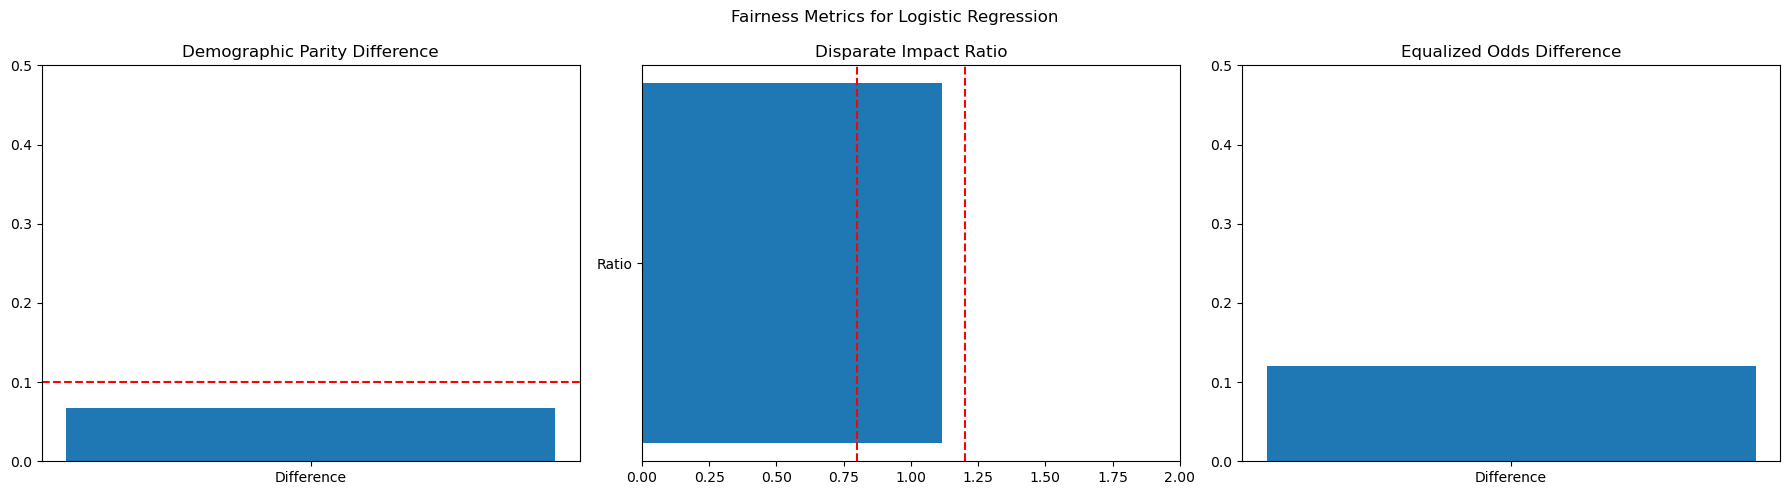

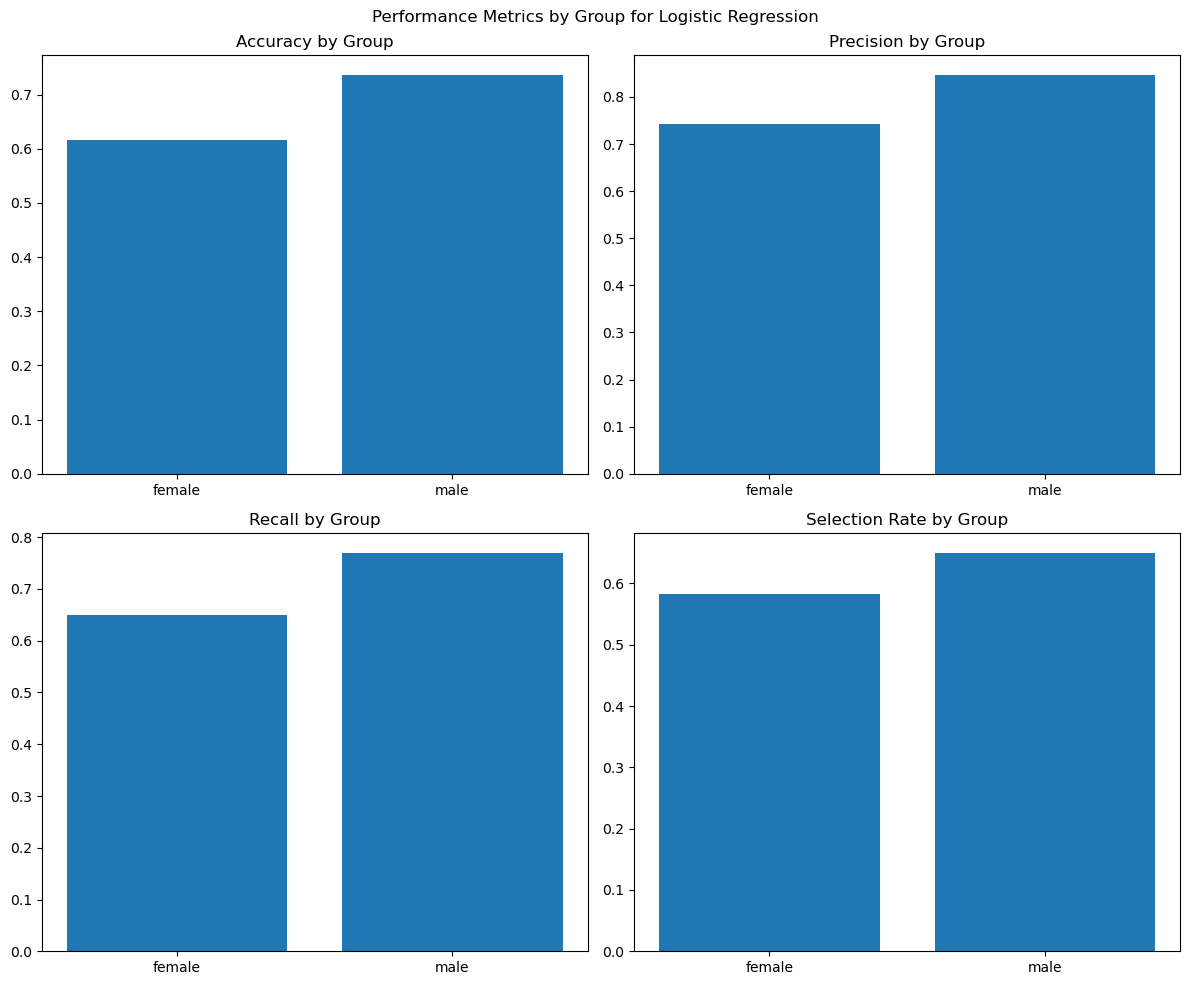


Random Forest Fairness Metrics:
Demographic Parity Difference: 0.0571
Equalized Odds Difference: 0.1250
Disparate Impact Ratio: 1.0952

Selection Rates by Group:
sensitive_feature_0
female    0.600000
male      0.657143
Name: selection_rate, dtype: float64
get_disparity_major_group()

Aequitas Fairness Table:
  attribute_name attribute_value  fpr_disparity  fdr_disparity  for_disparity
0         gender          female       1.333333       1.703704       1.217391
1         gender            male       1.000000       1.000000       1.000000


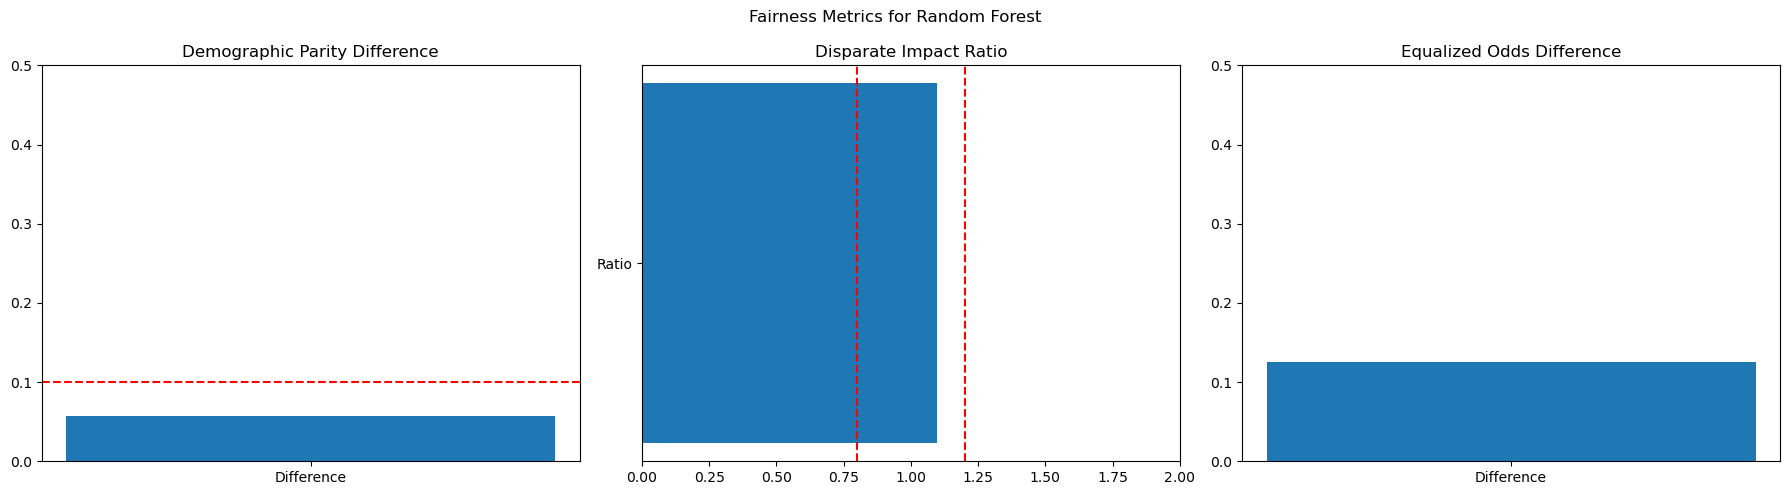

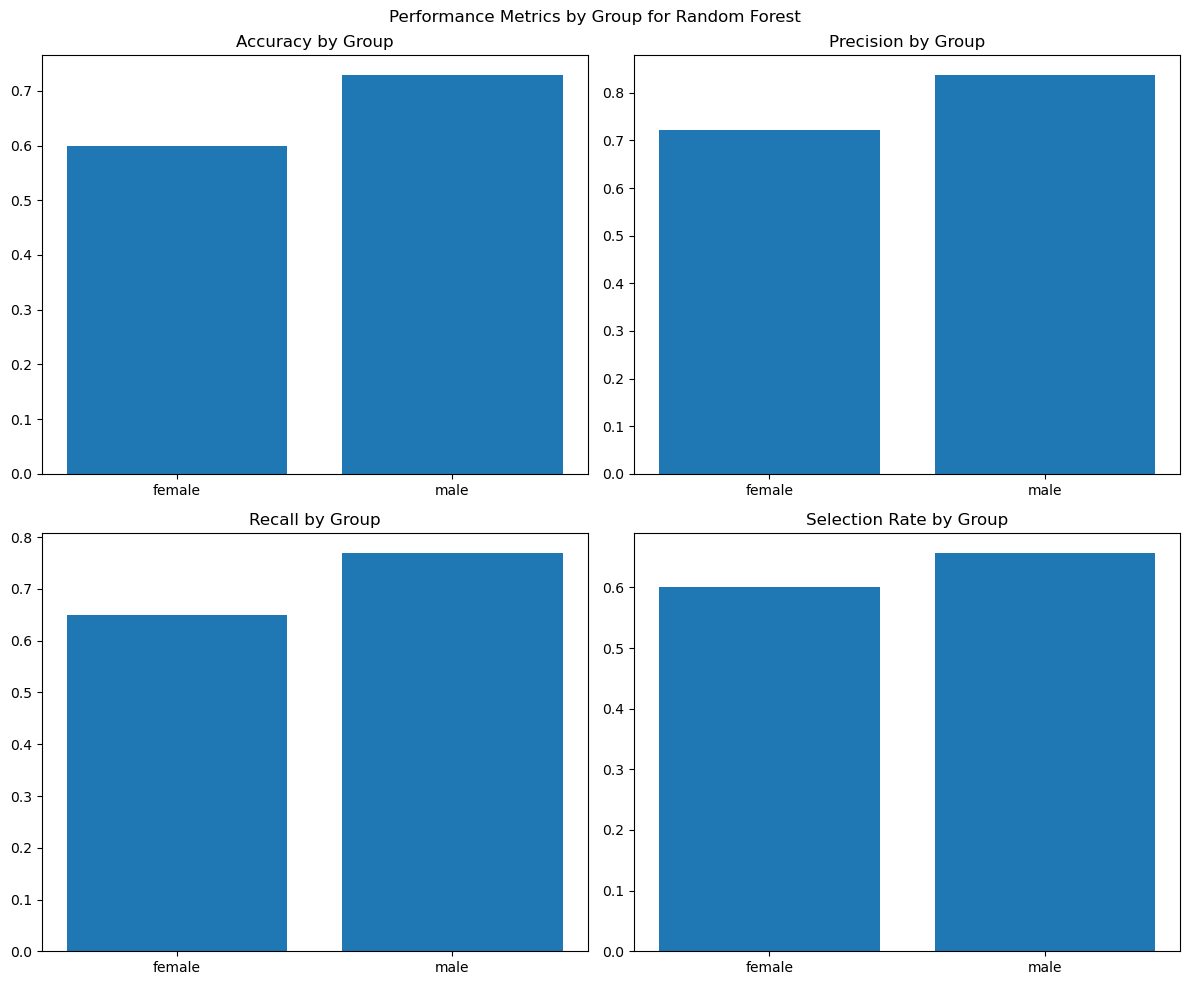


XGBoost Fairness Metrics:
Demographic Parity Difference: 0.0905
Equalized Odds Difference: 0.1100
Disparate Impact Ratio: 1.1467

Selection Rates by Group:
sensitive_feature_0
female    0.616667
male      0.707143
Name: selection_rate, dtype: float64
get_disparity_major_group()

Aequitas Fairness Table:
  attribute_name attribute_value  fpr_disparity  fdr_disparity  for_disparity
0         gender          female            1.0       1.337838       1.125858
1         gender            male            1.0       1.000000       1.000000


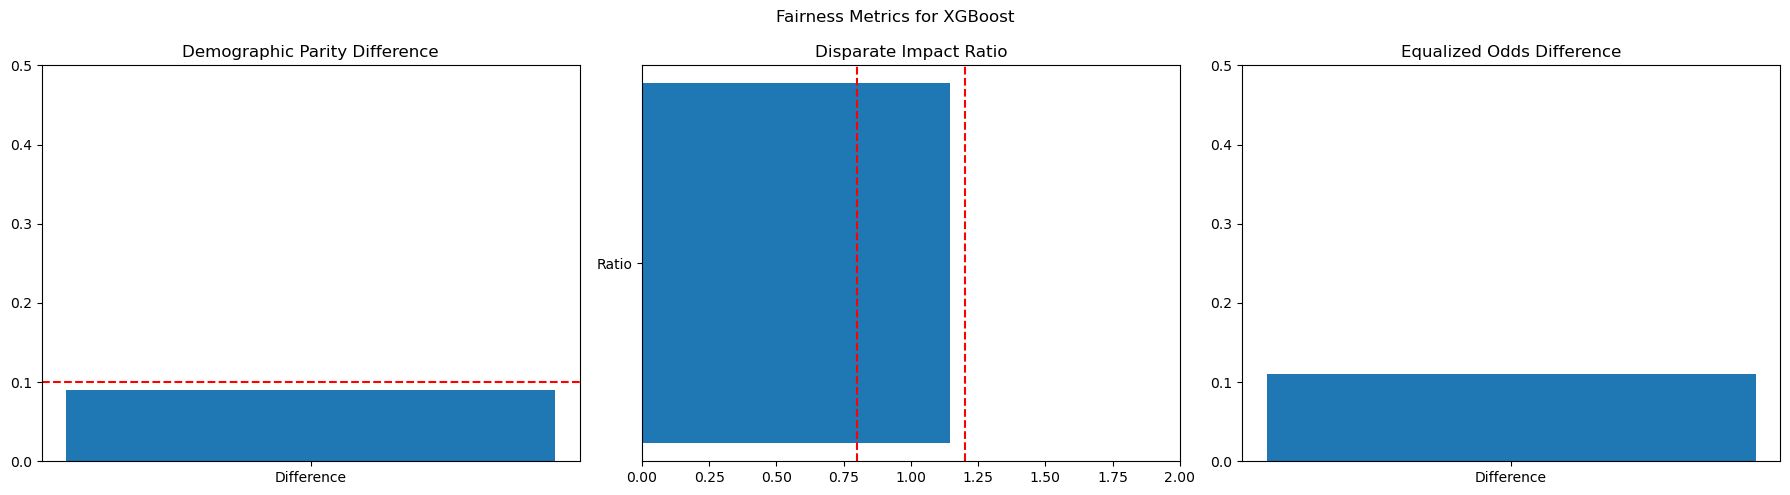

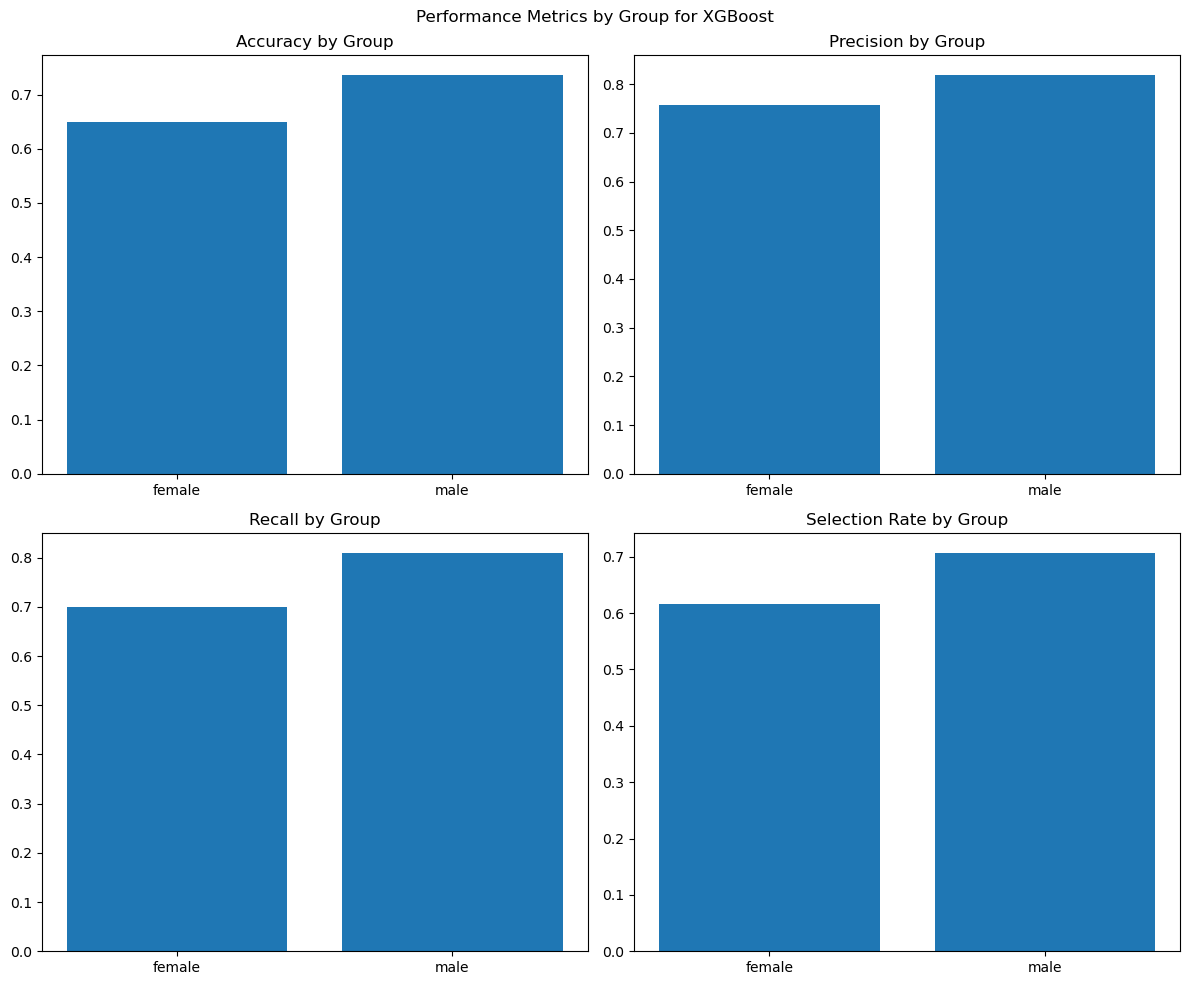

In [10]:
def main():
    print("=== German Credit Fairness Analysis ===")
    df = load_and_preprocess_data()
    print("\nData preview:")
    print(df.head())
    print(f"\nClass distribution:\n{df[TARGET].value_counts(normalize=True)}")
    data = prepare_data(df)
    results = train_and_evaluate_models(
        data["X_train_sm"], data["y_train_sm"],
        data["X_test"], data["y_test"]
    )
    test_df = data["X_test"].copy()
    test_df['y_true'] = data["y_test"]
    
    for model_name, result in results.items():
        test_df['y_pred'] = result['predictions']
        fairness_results = calculate_fairness_metrics(
            test_df['y_true'],
            test_df['y_pred'],
            test_df[SENSITIVE_FEATURE]
        )
        results[model_name]['fairness'] = fairness_results
        print(f"\n{model_name} Fairness Metrics:")
        print(f"Demographic Parity Difference: {fairness_results['demographic_parity_diff']:.4f}")
        print(f"Equalized Odds Difference: {fairness_results['equalized_odds_diff']:.4f}")
        print(f"Disparate Impact Ratio: {fairness_results['disparate_impact']:.4f}")
        print("\nSelection Rates by Group:")
        print(fairness_results['selection_rates'])
        aeq_results = aequitas_analysis(
            test_df, 
            'y_true', 
            'y_pred', 
            fairness_results['sensitive_str']
        )
        print("\nAequitas Fairness Table:")
        print(aeq_results['fairness'][['attribute_name', 'attribute_value', 'fpr_disparity', 'fdr_disparity', 'for_disparity']])
        plot_fairness_results(fairness_results, model_name)
        plot_group_metrics(fairness_results['metric_frame'], model_name)
    
    return results

if __name__ == "__main__":
    results = main()

### Results

**Demographic Parity Difference**
- Logistic Regression: 6.7%
- XGBoost: 9.1%
- Not Fair (Goal < 5%)

**Equalized Odds Difference**
- Logistic Regression: 12.0%
- XGBoost: 11.0%
- Not Fair (Goal < 10%)

**Disparate Impact Ratio**
- Logistic Regression: 1.11
- XGBoost: 1.15
- Fair (Range: 0.8–1.2)

**False Positive Rate (FPR) Disparity for Women**
- Logistic Regression: 1.29×
- XGBoost: 1.0×
- Only XGBoost is fair

### Key Takeaways

**Performance Bias**
- All models perform worse on the minority class ("bad" risk).
- Action: Use techniques like SMOTE (which you did) or class weights.

**Gender Bias**
- Men are consistently approved more often (Demographic Parity Difference).
- Women face higher false rejection rates (Equalized Odds, FPR disparity).
- Action: Try fairness-aware algorithms (e.g., fairlearn.reductions.GridSearch). Adjust decision thresholds per group.

**Best/Worst Model**
- Least Biased: Logistic Regression (smallest parity differences).
- Most Accurate: XGBoost (but slightly worse fairness).

## Key Findings

**1. Model Performance**

- All models (Logistic Regression, Random Forest, XGBoost) showed reasonable accuracy (~70%) but struggled with the minority class ("bad" risk), reflecting the dataset’s imbalance (70% "good" vs. 30% "bad").
- XGBoost performed slightly better in accuracy (71%) but exhibited marginally higher bias.

**2. Fairness Insights**

- Demographic Parity: Men were consistently approved 6–9% more often than women.
- Equalized Odds: Women faced 11–12.5% higher error rates (e.g., false rejections).
- Disparate Impact: Approval rates for men were 1.1–1.15× higher than women (within legal bounds but indicative of bias).
- Aequitas Audit: Women had up to 1.67× higher false discovery rates (approved applications were more likely to be incorrect).